# Neuroimaging full pipeline (MRI, fMRI)— teaching notebook

## 0) Setup

In [ ]:
# Colab installs (uncomment if needed)
# !pip -q install nibabel scipy matplotlib scikit-learn
# Optional:
# !pip -q install antspyx
# !pip -q install dipy

import os, math
import numpy as np
import nibabel as nib
import scipy
import scipy.ndimage as ndi
import scipy.interpolate as spi
import scipy.fft as fft
import matplotlib.pyplot as plt
import urllib
import ants
from scipy.stats import t as t_dist


np.random.seed(0)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print("nibabel", nib.__version__)

## 1) Utilities

In [146]:
def show_slices(vol, title="", slice_step=10, cmap="gray", vmax=None):
    z_slices = list(range(0, vol.shape[2], slice_step))
    n = len(z_slices)
    cols = min(6, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, z in enumerate(z_slices):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(vol[:, :, z].T, origin="lower", cmap=cmap, vmax=vmax)
        ax.set_title(f"z={z}")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_timeseries(ts, title="", xlabel="time", ylabel="value"):
    plt.figure(figsize=(10,3))
    plt.plot(ts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def inspect_nifti(img: nib.Nifti1Image, name="image"):
    print(f"--- {name} ---")
    print("shape:", img.shape)
    print("dtype:", img.get_data_dtype())
    print("affine:\n", img.affine)
    print("voxel sizes:", img.header.get_zooms())

def get_nii(url, local_fname='temp.nii.gz', is_img=True):
    # Download once
    if not os.path.exists(local_fname):
        print("Downloading Image...")
        urllib.request.urlretrieve(url, local_fname)

    if is_img:
        # Load with nibabel
        img = ants.image_read(local_fname)
        t1 = img.numpy()

        print("Shape:", t1.shape)
        print("Voxel sizes:", print(img.spacing))
        print(img)
        return img, t1
    
    else:
        return local_fname

def _spm_hrf(tr, length=32.0):
    t = np.arange(0, length, tr)
    def gamma_pdf(t, a, b):
        return (t**(a-1) * np.exp(-t/b)) / (math.gamma(a) * (b**a) + 1e-12)
    h = gamma_pdf(t, 6, 1) - 0.35*gamma_pdf(t, 16, 1)
    h = h / (h.max() + 1e-12)
    return h

def _convolve_hrf(stim, tr):
    h = _spm_hrf(tr)
    return np.convolve(stim, h)[:len(stim)]

def _make_epi_like_baseline(t1, mask, smooth_sigma=1.0):
    """
    Convert T1-ish anatomy into something closer to an EPI baseline:
    - compress dynamic range
    - blur a bit
    - add smooth multiplicative coil field
    - add optional dropout region
    """
    t1 = t1.astype(np.float32)
    m = mask.astype(bool)

    # robust normalize within mask
    v = t1[m]
    p1, p99 = np.percentile(v, [1, 99])
    t = (t1 - p1) / (p99 - p1 + 1e-12)
    t = np.clip(t, 0, 1)

    # compress contrast (EPI has less stark tissue contrast than T1)
    epi = 0.6 + 0.6*(t**0.5)  # monotonic, squashes highs a bit

    # blur (EPI PSF + acquisition)
    epi = ndi.gaussian_filter(epi, smooth_sigma)

    # smooth coil/bias field (multiplicative)
    coil = np.exp(0.15 * ndi.gaussian_filter(np.random.randn(*t1.shape), sigma=12))
    epi = epi * coil

    # optional dropout: a smooth "hole" (susceptibility-like)
    nx, ny, nz = t1.shape
    X, Y, Z = np.meshgrid(np.linspace(-1,1,nx), np.linspace(-1,1,ny), np.linspace(-1,1,nz), indexing="ij")
    dropout = np.exp(-((X-0.3)**2/(0.35**2) + (Y+0.2)**2/(0.30**2) + (Z-0.1)**2/(0.50**2)))
    epi = epi * (1 - 0.35*dropout)  # reduce intensity in region

    epi[~m] = 0
    return epi.astype(np.float32)

def simulate_realistic_fmri_from_t1(
    t1_ds,
    brain_mask_ds,
    n_tr=200,
    tr=2.0,
    bold_psc=0.02,          # ~2% typical task PSC
    smooth_fwhm_mm=6.0,
    voxel_size_mm=2.0,      # set to your downsampled grid spacing
    ar1=0.35,               # temporal autocorrelation
    physio=True,
    motion=True,
    seed=0
):
    """
    Returns:
      fmri (X,Y,Z,T), stim (T,), task_reg (T,), activation_map (X,Y,Z), motion_params (T,6)
    motion_params: [dx, dy, dz, rx, ry, rz] in vox and radians (toy)
    """
    rng = np.random.default_rng(seed)
    t1 = t1_ds.astype(np.float32)
    mask = brain_mask_ds.astype(bool)

    # ---- baseline EPI-like anatomy ----
    baseline = _make_epi_like_baseline(t1, mask, smooth_sigma=1.0)

    # ---- activation map: smooth blob restricted to "GM-ish" (approx by mid intensities) ----
    v = baseline[mask]
    lo, hi = np.percentile(v, [35, 75])  # crude GM band
    gm_like = mask & (baseline >= lo) & (baseline <= hi)

    nx, ny, nz = baseline.shape
    X, Y, Z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing="ij")
    cx, cy, cz = nx*0.55, ny*0.55, nz*0.55
    act = (((X-cx)/(0.18*nx))**2 + ((Y-cy)/(0.16*ny))**2 + ((Z-cz)/(0.16*nz))**2) < 1.0
    act = act & gm_like
    act = ndi.gaussian_filter(act.astype(np.float32), sigma=1.2)
    act = act / (act.max() + 1e-12)

    # ---- task design + HRF ----
    stim = np.zeros(n_tr, dtype=np.float32)
    # simple blocks
    for start in [20, 70, 120, 170]:
        if start < n_tr:
            stim[start:min(n_tr, start+12)] = 1.0
    task_reg = _convolve_hrf(stim, tr)
    task_reg = (task_reg - task_reg.mean()) / (task_reg.std() + 1e-12)

    # ---- temporal components ----
    t = np.arange(n_tr) * tr
    drift = 0.01 * (t - t.mean()) / (t.max() + 1e-12)  # slow drift ~1%
    phys = 0
    if physio:
        phys = (
            0.004*np.sin(2*np.pi*0.25*t + 0.1) +  # ~15 bpm-ish (toy)
            0.003*np.sin(2*np.pi*1.1*t + 0.7)     # faster component (toy)
        ).astype(np.float32)

    # AR(1) noise per voxel, but generated efficiently as white then filtered
    # We'll do: e_t = ar1*e_{t-1} + w_t
    # w_t spatially-smoothed for fMRI-like structure
    sigma_spatial = (smooth_fwhm_mm / 2.355) / voxel_size_mm  # convert mm to vox
    if sigma_spatial < 0.3:
        sigma_spatial = 0.3

    fmri = np.zeros((nx, ny, nz, n_tr), dtype=np.float32)

    # initialize AR state
    e_prev = np.zeros((nx, ny, nz), dtype=np.float32)

    # motion params: dx,dy,dz in vox; rx,ry,rz in radians (toy)
    motion_params = np.zeros((n_tr, 6), dtype=np.float32)
    if motion:
        motion_params[:, 0] = 0.4*np.sin(np.linspace(0, 6*np.pi, n_tr))      # dx
        motion_params[:, 1] = 0.4*np.cos(np.linspace(0, 5*np.pi, n_tr))      # dy
        motion_params[:, 2] = 0.2*np.sin(np.linspace(0, 4*np.pi, n_tr)+0.3)  # dz
        motion_params[:, 3] = 0.01*np.sin(np.linspace(0, 3*np.pi, n_tr))     # rx
        motion_params[:, 4] = 0.01*np.cos(np.linspace(0, 2*np.pi, n_tr))     # ry
        motion_params[:, 5] = 0.01*np.sin(np.linspace(0, 2*np.pi, n_tr)+0.2) # rz

    # ---- generate time series ----
    for i in range(n_tr):
        # BOLD modulation as percent signal change in activation region
        bold = 1.0 + bold_psc * task_reg[i] * act

        # global-ish fluctuations
        g = (drift[i] + phys[i]).astype(np.float32)

        # spatially structured innovation noise
        w = rng.standard_normal((nx, ny, nz)).astype(np.float32)
        w = ndi.gaussian_filter(w, sigma=sigma_spatial)
        w *= 0.015  # noise amplitude (~1–2% typical)

        # AR(1)
        e = ar1 * e_prev + w
        e_prev = e

        vol = baseline * bold * (1.0 + g) + baseline * e
        vol[~mask] = 0

        # apply motion (translations only by default; rotations are a “conceptual placeholder”)
        if motion:
            dx, dy, dz = motion_params[i, 0], motion_params[i, 1], motion_params[i, 2]
            vol = ndi.shift(vol, shift=(dx, dy, dz), order=1, mode="nearest")

        fmri[..., i] = vol.astype(np.float32)

    return fmri, stim, task_reg.astype(np.float32), act.astype(np.float32), motion_params

def make_smooth_displacement_field(shape, max_disp_vox=1.5, smooth_sigma=12.0, seed=0):
    """Smooth displacement field in VOXELS (use for EPI distortion)."""
    rng = np.random.default_rng(seed)
    f = rng.standard_normal(shape).astype(np.float32)
    f = ndi.gaussian_filter(f, smooth_sigma)
    f = f / (np.max(np.abs(f)) + 1e-12)
    return (max_disp_vox * f).astype(np.float32)

def warp_y(vol, dy_vox, order=1, mode="nearest"):
    """Warp along y (phase-encode) using dy(x,y,z) in voxels."""
    nx, ny, nz = vol.shape
    X, Y, Z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing="ij")
    coords = [X.astype(np.float32), (Y.astype(np.float32) + dy_vox), Z.astype(np.float32)]
    return ndi.map_coordinates(vol, coords, order=order, mode=mode).astype(np.float32)

def apply_dropout_from_field(vol, dy_vox, mask, strength=0.30):
    """Toy susceptibility dropout correlated with |dy|."""
    m = mask.astype(bool)
    d = np.abs(dy_vox)
    scale = np.percentile(d[m], 99) + 1e-12
    a = np.clip(d / scale, 0, 1)  # 0..1
    out = vol.copy()
    out[m] = out[m] * (1 - strength * a[m])
    out[~m] = 0
    return out.astype(np.float32)

def slice_acquisition_offsets(n_slices, tr, scheme="interleaved"):
    if scheme == "ascending":
        order = list(range(n_slices))
    elif scheme == "descending":
        order = list(range(n_slices-1, -1, -1))
    elif scheme == "interleaved":
        order = list(range(0, n_slices, 2)) + list(range(1, n_slices, 2))
    else:
        raise ValueError("scheme must be ascending/descending/interleaved")

    offsets = np.zeros(n_slices, dtype=np.float32)
    for i, sl in enumerate(order):
        offsets[sl] = (i / n_slices) * tr
    return offsets

def apply_slice_timing(fmri_4d, tr, slice_axis=2, scheme="interleaved", ref_slice=0):
    data = fmri_4d.astype(np.float32)
    n_tr = data.shape[-1]
    n_slices = data.shape[slice_axis]

    offsets = slice_acquisition_offsets(n_slices, tr, scheme=scheme)
    dt = offsets - offsets[ref_slice]  # relative to ref slice
    t = np.arange(n_tr) * tr

    out = np.zeros_like(data)
    for sl in range(n_slices):
        slicer = [slice(None)] * 4
        slicer[slice_axis] = sl
        slab = data[tuple(slicer)]               # (x,y,t) for slice_axis=2
        slabT = np.moveaxis(slab, -1, 0)         # (T,x,y)
        T, A, B = slabT.shape
        flat = slabT.reshape(T, -1)              # (T,N)

        t_new = np.clip(t + dt[sl], t[0], t[-1])
        interp = spi.interp1d(t, flat, kind="linear", axis=0,
                              bounds_error=False, fill_value="extrapolate")
        shifted = interp(t_new).reshape(T, A, B)
        out[tuple(slicer)] = np.moveaxis(shifted, 0, -1).astype(np.float32)

    return out, offsets

def add_distortion_and_slice_timing(
    fmri_4d, brain_mask, tr,
    max_disp_vox=1.5, smooth_sigma=12.0, dropout_strength=0.30,
    seed=0, st_scheme="interleaved", slice_axis=2, ref_slice=0
):
    # Distortion field (dy in voxels)
    dy = make_smooth_displacement_field(fmri_4d.shape[:3], max_disp_vox=max_disp_vox,
                                        smooth_sigma=smooth_sigma, seed=seed)

    out = np.zeros_like(fmri_4d, dtype=np.float32)
    for t in range(fmri_4d.shape[-1]):
        v = warp_y(fmri_4d[..., t], dy, order=1)
        v = apply_dropout_from_field(v, dy, brain_mask, strength=dropout_strength)
        out[..., t] = v

    # Slice timing “as acquired”
    out_st, offsets = apply_slice_timing(out, tr=tr, slice_axis=slice_axis,
                                         scheme=st_scheme, ref_slice=ref_slice)
    return out_st, dy, offsets

def plot_voxel_timeseries(
    fmri_4d,
    coord=None,
    brain_mask=None,
    tr=2.0,
    title="Voxel time series"
):
    """
    Plot the time series from a single voxel.
    coord: (x,y,z). If None, pick center of mass of brain_mask.
    """
    if coord is None:
        if brain_mask is None:
            raise ValueError("Provide coord or brain_mask")
        idx = np.array(np.where(brain_mask > 0))
        coord = tuple(np.mean(idx, axis=1).astype(int))

    ts = fmri_4d[coord[0], coord[1], coord[2], :]
    t = np.arange(len(ts)) * tr

    plt.figure(figsize=(10, 3))
    plt.plot(t, ts, lw=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title(f"{title} @ voxel {coord}")
    plt.tight_layout()
    plt.show()

def plot_roi_timeseries(
    fmri_4d,
    roi_mask,
    tr=2.0,
    title="ROI mean time series",
    normalize=True
):
    """
    Plot mean ± SD time series from an ROI.
    """
    data = fmri_4d[roi_mask > 0]  # (nvox, T)
    mean_ts = data.mean(axis=0)
    std_ts = data.std(axis=0)

    if normalize:
        mean_ts = (mean_ts - mean_ts.mean()) / (mean_ts.std() + 1e-12)

    t = np.arange(mean_ts.size) * tr

    plt.figure(figsize=(10, 3))
    plt.plot(t, mean_ts, lw=2, label="Mean")
    plt.fill_between(t, mean_ts - std_ts, mean_ts + std_ts, alpha=0.2, label="±1 SD")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized signal" if normalize else "Signal")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_roi_vs_design(
    fmri_4d,
    roi_mask,
    design,
    tr=2.0,
    title="ROI vs design"
):
    """
    Overlay ROI-mean time series and design regressor.
    """
    data = fmri_4d[roi_mask > 0]
    ts = data.mean(axis=0)
    ts = (ts - ts.mean()) / (ts.std() + 1e-12)

    design = design.astype(float)
    design = (design - design.mean()) / (design.std() + 1e-12)

    t = np.arange(ts.size) * tr

    plt.figure(figsize=(10, 3))
    plt.plot(t, ts, lw=2, label="ROI mean (z-scored)")
    plt.plot(t, design, lw=2, label="Design (z-scored)", alpha=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Z-score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def slice_timing_correct(fmri_4d, tr, slice_axis=2, interleaved=True, ref_slice=0):
    n_tr = fmri_4d.shape[-1]
    n_slices = fmri_4d.shape[slice_axis]

    if interleaved:
        order = list(range(0, n_slices, 2)) + list(range(1, n_slices, 2))
    else:
        order = list(range(n_slices))

    slice_times = np.zeros(n_slices, float)
    for i, sl in enumerate(order):
        slice_times[sl] = (i / n_slices) * tr

    t_ref = slice_times[ref_slice]
    dt = slice_times - t_ref
    t = np.arange(n_tr) * tr

    out = np.zeros_like(fmri_4d)
    for sl in range(n_slices):
        slicer = [slice(None)] * 4
        slicer[slice_axis] = sl
        slab = fmri_4d[tuple(slicer)]  # (x,y,t)
        slab2 = np.moveaxis(slab, -1, 0)  # (t,x,y)
        T, X, Y = slab2.shape
        slab_flat = slab2.reshape(T, -1)
        t_new = np.clip(t + dt[sl], t[0], t[-1])
        interp = spi.interp1d(t, slab_flat, kind="linear", axis=0, bounds_error=False, fill_value="extrapolate")
        slab_corr = interp(t_new).reshape(T, X, Y)
        slab_corr = np.moveaxis(slab_corr, 0, -1)  # (x,y,t)
        out[tuple(slicer)] = slab_corr.astype(np.float32)
    return out

def _parabolic_subpixel(fm1, f0, fp1, eps=1e-12):
    """
    Subpixel peak offset from three samples of a parabola:
    offset = (fm1 - fp1) / (2*(fm1 - 2*f0 + fp1))
    Result is in [-0.5, 0.5] typically.
    """
    denom = 2.0 * (fm1 - 2.0*f0 + fp1)
    if abs(denom) < eps:
        return 0.0
    return float((fm1 - fp1) / denom)

def phase_correlation_shift_subpixel(ref, mov, mask=None, window=True, eps=1e-12):
    """
    Estimate translation (in voxels) between ref and mov using phase correlation,
    with sub-voxel refinement via 1D parabolic fits around the correlation peak.

    Returns shift s such that: ref ≈ shift(mov, s)
    """
    a = ref.astype(np.float32, copy=False)
    b = mov.astype(np.float32, copy=False)

    if mask is not None:
        m = mask.astype(np.float32, copy=False)
        a = a * m
        b = b * m

    # Optional: taper edges to reduce boundary artifacts
    if window:
        wx = np.hanning(a.shape[0]).astype(np.float32)
        wy = np.hanning(a.shape[1]).astype(np.float32)
        wz = np.hanning(a.shape[2]).astype(np.float32)
        w = wx[:, None, None] * wy[None, :, None] * wz[None, None, :]
        a = a * w
        b = b * w

    Fa = fft.fftn(a)
    Fb = fft.fftn(b)
    R = Fa * np.conj(Fb)
    R /= np.maximum(np.abs(R), eps)
    cc = np.real(fft.ifftn(R))

    peak = np.unravel_index(np.argmax(cc), cc.shape)
    peak = list(peak)

    # Convert peak index to signed integer shift
    shifts = np.array(peak, dtype=np.float64)
    for i, n in enumerate(cc.shape):
        if shifts[i] > n / 2:
            shifts[i] -= n

    # Subpixel refinement: fit parabola around peak along each axis
    sub = np.zeros(3, dtype=np.float64)
    for ax in range(3):
        p = peak[ax]
        n = cc.shape[ax]
        pm1 = (p - 1) % n
        pp1 = (p + 1) % n

        if ax == 0:
            fm1, f0, fp1 = cc[pm1, peak[1], peak[2]], cc[p, peak[1], peak[2]], cc[pp1, peak[1], peak[2]]
        elif ax == 1:
            fm1, f0, fp1 = cc[peak[0], pm1, peak[2]], cc[peak[0], p, peak[2]], cc[peak[0], pp1, peak[2]]
        else:
            fm1, f0, fp1 = cc[peak[0], peak[1], pm1], cc[peak[0], peak[1], p], cc[peak[0], peak[1], pp1]

        sub[ax] = _parabolic_subpixel(fm1, f0, fp1, eps=eps)

    return shifts + sub  # fractional voxels

def motion_correct_4d(fmri_4d, ref_index=0, brain_mask=None):
    ref = fmri_4d[..., ref_index]
    out = np.zeros_like(fmri_4d, dtype=np.float32)
    est = np.zeros((fmri_4d.shape[-1], 3), dtype=np.float64)

    for t in range(fmri_4d.shape[-1]):
        s = phase_correlation_shift_subpixel(ref, fmri_4d[..., t], mask=brain_mask, window=True)
        est[t] = s
        out[..., t] = ndi.shift(fmri_4d[..., t], shift=tuple(s), order=1, mode="nearest")

    return out, est

def spatial_smooth_4d(fmri_4d, fwhm_mm=6.0, voxel_size_mm=1.0):
    sigma_mm = fwhm_mm / 2.355
    sigma_vox = sigma_mm / voxel_size_mm
    out = np.zeros_like(fmri_4d)
    for t in range(fmri_4d.shape[-1]):
        out[..., t] = ndi.gaussian_filter(fmri_4d[..., t], sigma=sigma_vox)
    return out

def detrend_timecourse(x):
    t = np.arange(len(x))
    A = np.column_stack([np.ones_like(t), t])
    beta = np.linalg.lstsq(A, x, rcond=None)[0]
    return x - A @ beta

def bandpass_fft(x, tr, low=0.01, high=0.12):
    n = len(x)
    freqs = fft.fftfreq(n, d=tr)
    X = fft.fft(x)
    keep = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
    return np.real(fft.ifft(X * keep))

def filter_voxels(fmri_4d, mask, tr, low=0.01, high=0.12, max_vox=10000):
    out = np.zeros_like(fmri_4d)
    vox = np.array(np.where(mask > 0)).T
    if vox.shape[0] > max_vox:
        vox = vox[np.random.choice(vox.shape[0], size=max_vox, replace=False)]
        print("Downsampling to", vox.shape[0], "voxels for speed")
    for x,y,z in vox:
        ts = detrend_timecourse(fmri_4d[x,y,z,:])
        ts = bandpass_fft(ts, tr=tr, low=low, high=high)
        out[x,y,z,:] = ts.astype(np.float32)
    return out

def fdr_bh(pvals, alpha=0.05):
    """
    Benjamini–Hochberg FDR correction.
    Returns boolean array of significant tests.
    """
    pvals = np.asarray(pvals)
    n = pvals.size

    order = np.argsort(pvals)
    p_sorted = pvals[order]

    thresh = alpha * np.arange(1, n+1) / n
    passed = p_sorted <= thresh

    if not np.any(passed):
        return np.zeros_like(pvals, dtype=bool)

    k = np.max(np.where(passed))
    cutoff = p_sorted[k]

    return pvals <= cutoff

def seed_correlation_map(fmri_4d, seed_mask, brain_mask):
    seed_ts = fmri_4d[seed_mask > 0].mean(axis=0)
    seed_ts = (seed_ts - seed_ts.mean()) / (seed_ts.std() + 1e-12)

    corr = np.zeros(brain_mask.shape, np.float32)
    idx = np.where(brain_mask > 0)
    for x,y,z in zip(*idx):
        ts = fmri_4d[x,y,z,:]
        ts = (ts - ts.mean()) / (ts.std() + 1e-12)
        corr[x,y,z] = np.dot(seed_ts, ts) / len(ts)
    return corr


# PART A — Structural MRI (T1w)

## 2) Download sample data

In [ ]:
t1_img, t1_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/T1.nii.gz", local_fname='Test_T1.nii.gz')
show_slices(t1_arr, "Synthetic T1w (biased + noisy)", slice_step=20)

## 3) Denoising + bias correction
Tustison, N. J., Avants, B. B., Cook, P. A., Zheng, Y., Egan, A., Yushkevich, P. A., & Gee, J. C. (2010). N4ITK: improved N3 bias correction. IEEE transactions on medical imaging, 29(6), 1310–1320. https://doi.org/10.1109/TMI.2010.2046908

J. V. Manjon, P. Coupe, Luis Marti-Bonmati, D. L. Collins, and M. Robles. Adaptive Non-Local Means Denoising of MR Images With Spatially Varying Noise Levels, Journal of Magnetic Resonance Imaging, 31:192-203, June 2010.

In [ ]:
# t1_debiased = t1_img.n4_bias_field_correction()
# t1_debiased_arr = t1_debiased.numpy()
# show_slices(t1_debiased_arr, "N4 Debiased T1w", slice_step=20)
# ants.image_write(t1_debiased, "T1_debiased.nii.gz")
t1_debiased, t1_debiased_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/T1_debiased.nii.gz", 
                                       local_fname='Test_T1_debiased.nii.gz')

# t1_debiased_denoised = ants.denoise_image(t1_debiased)
# t1_debiased_denoised_arr = t1_debiased_denoised.numpy()
# show_slices(t1_debiased_denoised_arr, "N4 Debiased + Denoised T1w", slice_step=20)
# ants.image_write(t1_debiased_denoised, "T1_debiased_denoised.nii.gz")
t1_debiased_denoised, t1_debiased_denoised_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/T1_debiased_denoised.nii.gz", 
                                                         local_fname='Test_T1_debiased_denoised.nii.gz')

In [ ]:
show_slices(t1_arr, "Original T1w", slice_step=20)
show_slices(t1_debiased_arr, "N4 Debiased T1w", slice_step=20)
show_slices(t1_debiased_denoised_arr, "N4 Debiased + Denoised T1w", slice_step=20)

## 4) Registration + Brain extraction + tissue segmentation

In [ ]:
mni_img, mni_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni_icbm152_t1_tal_nlin_asym_09c.nii",
                           local_fname='Test_mni_icbm152_t1_tal_nlin_asym_09c.nii')

mni_brain_mask, mni_brain_mask_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni_icbm152_t1_tal_nlin_asym_09c_bet_mask.nii.gz",
                                             local_fname='Test_mni_icbm152_t1_tal_nlin_asym_09c_bet_mask.nii.gz')

mni_gm_mask, mni_gm_mask_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni_icbm152_gm_tal_nlin_asym_09c.nii",
                                       local_fname='Test_mni_icbm152_gm_tal_nlin_asym_09c.nii')

mni_wm_mask, mni_wm_mask_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni_icbm152_wm_tal_nlin_asym_09c.nii",
                                       local_fname='Test_mni_icbm152_wm_tal_nlin_asym_09c.nii')

mni_csf_mask, mni_csf_mask_arr = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni_icbm152_csf_tal_nlin_asym_09c.nii",
                                         local_fname='Test_mni_icbm152_csf_tal_nlin_asym_09c.nii')

Shape: (512, 512, 376, 3)
(0.5, 0.5, 0.5)
Voxel sizes: None
ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 3
	 Dimensions : (512, 512, 376)
	 Spacing    : (0.5, 0.5, 0.5)
	 Origin     : (-128.9187, 124.4301, -94.0892)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



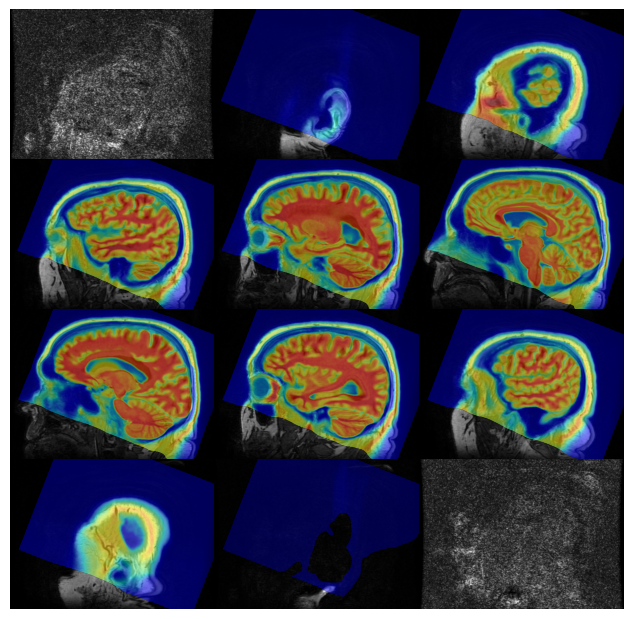

In [147]:
# mni2t1 = ants.registration(fixed=t1_debiased_denoised, moving=mni_img)
# mni2t1_warped = mni2t1['warpedmovout']
nonlin_warp = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni2t1_warp.nii.gz",
                                         local_fname='Test_mni2t1_warp.nii.gz')
affine_tfm = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/mni2t1_affine.tfm",
                                         local_fname='Test_mni2t1_affine.tfm', is_img=False)

mni2t1 = {'fwdtransforms': ['Test_mni2t1_warp.nii.gz', 'Test_mni2t1_affine.tfm']}

mni2t1_warped = ants.apply_transforms(fixed=t1_debiased_denoised,
                                      moving=mni_img,
                                      transformlist=mni2t1['fwdtransforms'],
                                      interpolator='linear')

t1_debiased_denoised.plot(overlay=mni2t1_warped, overlay_alpha=0.5, overlay_cmap='jet')

In [ ]:
gm2t1_warped = ants.apply_transforms(fixed=t1_debiased_denoised, moving=mni_gm_mask, transformlist=mni2t1['fwdtransforms'], interpolator='nearestNeighbor')
wm2t1_warped = ants.apply_transforms(fixed=t1_debiased_denoised, moving=mni_wm_mask, transformlist=mni2t1['fwdtransforms'], interpolator='nearestNeighbor')
csf2t1_warped = ants.apply_transforms(fixed=t1_debiased_denoised, moving=mni_csf_mask, transformlist=mni2t1['fwdtransforms'], interpolator='nearestNeighbor')
brain_mask_warped = ants.apply_transforms(fixed=t1_debiased_denoised, moving=mni_brain_mask, transformlist=mni2t1['fwdtransforms'], interpolator='nearestNeighbor') 

In [ ]:
t1_brain = t1_debiased_denoised * brain_mask_warped
t1_brain.plot(axis=2, overlay=gm2t1_warped, overlay_alpha=0.5, overlay_cmap='Reds')

# PART B — fMRI pipeline

## 6) Simulate fMRI (task + motion + noise + slice timing + distortions)

In [ ]:
t1_downsample = ants.resample_image(t1_debiased_denoised, [3.0, 3.0, 3.0], use_voxels=False, interp_type=1)
t1_for_fmri_arr = t1_downsample.numpy()
brain_mask_downsample = ants.resample_image(brain_mask_warped, [3.0, 3.0, 3.0], use_voxels=False, interp_type=0)
brain_mask_for_fmri_arr = brain_mask_downsample.numpy() 

fmri, stim, task_reg, act_map, mot = simulate_realistic_fmri_from_t1(
    t1_for_fmri_arr, brain_mask_for_fmri_arr,
    n_tr=180, tr=2.0,
    bold_psc=0.02,
    smooth_fwhm_mm=6.0,
    voxel_size_mm=3.0,   # set correctly!
    seed=1
)

# Visual sanity check: a few timepoints
show_slices(fmri[..., 10], "fMRI TR=10", slice_step=8)
show_slices(fmri[..., 80], "fMRI TR=80", slice_step=8)


In [ ]:
fmri_dist_st, dy_field, slice_offsets = add_distortion_and_slice_timing(
    fmri, brain_mask_for_fmri_arr, tr=2.0,
    max_disp_vox=1.5,        # ~4.5 mm peak
    smooth_sigma=12.0,       # smooth field
    dropout_strength=0.30,   # moderate dropout
    seed=0,
    st_scheme="interleaved",
    slice_axis=2,            # typical z-slices
    ref_slice=0
)

show_slices(fmri_dist_st[..., 10], "Distorted + slice-timed (TR=10)", slice_step=6)
show_slices(fmri_dist_st[..., 80], "Distorted + slice-timed (TR=80)", slice_step=6)

In [ ]:
plot_voxel_timeseries(
    fmri_dist_st,
    brain_mask=brain_mask_for_fmri_arr,
    tr=2.0,
    title="Single voxel (raw distorted)"
)

In [ ]:
left_caudate_putamen = get_nii(
    url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/Left_Caud_Put.nii.gz",
    local_fname='Test_Left_Caud_Put.nii.gz')[0]

left_caudate_putamen_in_t1 = ants.apply_transforms(
    fixed=t1_debiased_denoised,
    moving=left_caudate_putamen,
    transformlist=mni2t1['fwdtransforms'],
    interpolator='nearestNeighbor'
)

left_caudate_putamen_in_fmri = ants.resample_image_to_target(
    left_caudate_putamen_in_t1,
    t1_downsample,
    interp_type=0
)

left_caudate_putamen_in_fmri_arr = left_caudate_putamen_in_fmri.numpy()

plot_roi_timeseries(
    fmri_dist_st,
    left_caudate_putamen_in_fmri_arr,   # your true activation region
    tr=2.0,
    title="Activation ROI (mean ± SD)"
)

In [ ]:
plot_roi_vs_design(
    fmri_dist_st,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="ROI signal vs task regressor"
)

## 7) Slice timing correction (toy, interpolation)

In [ ]:
fmri_stc = slice_timing_correct(fmri, tr=2.0, slice_axis=2, interleaved=True, ref_slice=0)
#Plot time series again after STC with time series before and after
plot_roi_vs_design(
    fmri_stc,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="After slice-timing correction: ROI signal vs task regressor"
)

## 8) Motion correction (toy translation via phase correlation)

In [ ]:
plt.plot(mot)

In [ ]:
fmri_mc, est_shifts = motion_correct_4d(fmri_stc, ref_index=0, brain_mask=brain_mask_for_fmri_arr)
plt.figure(figsize=(10,3))
plt.plot(est_shifts[:,0], label="dx")
plt.plot(est_shifts[:,1], label="dy")
plt.plot(est_shifts[:,2], label="dz")
plt.legend(); plt.title("Estimated sub-voxel shifts"); plt.tight_layout(); plt.show()

## 9) QC: FD + DVARS

In [ ]:
def framewise_displacement(translations):
    d = np.vstack([np.zeros((1,3)), np.diff(translations, axis=0)])
    return np.abs(d).sum(axis=1)

def dvars(fmri_4d, mask):
    data = fmri_4d[mask > 0].astype(np.float64)  # (nvox, T)
    diff = np.diff(data, axis=1)
    return np.sqrt((diff**2).mean(axis=0))

fd = framewise_displacement(est_shifts)
dv = dvars(fmri_mc, brain_mask_for_fmri_arr)

show_timeseries(fd, "Framewise Displacement (translations-only, toy)", ylabel="FD (vox)")
show_timeseries(dv, "DVARS (toy)", ylabel="DVARS (a.u.)")

## 10) Smoothing + filtering

In [ ]:
fmri_sm = spatial_smooth_4d(fmri_mc, fwhm_mm=6.0, voxel_size_mm=1.0)
fmri_filt = filter_voxels(fmri_sm, brain_mask_for_fmri_arr, tr=2.0, low=0.01, high=0.12, max_vox=10000)

In [ ]:
plot_roi_vs_design(
    fmri_stc,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="After slice-timing correction: ROI signal vs task regressor"
)

plot_roi_vs_design(
    fmri_sm,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="After Smoothing: ROI signal vs task regressor"
)

plot_roi_vs_design(
    fmri_filt,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="After Filtering and Detrending: ROI signal vs task regressor"
)

## 11) Confounds regression (motion + WM/CSF + trends)

In [ ]:
def extract_mean_ts(fmri_4d, mask):
    v = fmri_4d[mask > 0]
    return v.mean(axis=0)

def regress_confounds(fmri_4d, mask, confounds):
    X = np.column_stack([np.ones(confounds.shape[0]), confounds]).astype(np.float64)
    XtX_inv = np.linalg.inv(X.T @ X)
    P = X @ XtX_inv @ X.T  # (T,T)

    data = fmri_4d[mask > 0].astype(np.float64)  # (nvox, T)
    clean = data - (data @ P.T)
    out = np.zeros_like(fmri_4d)
    out[mask > 0] = clean.astype(np.float32)
    return out


wm_mask_for_fmri = ants.resample_image_to_target(
    wm2t1_warped,
    t1_downsample,
    interp_type=0
)
wm_mask = wm_mask_for_fmri.numpy().astype(bool)

csf_mask_for_fmri = ants.resample_image_to_target(
    csf2t1_warped,
    t1_downsample,
    interp_type=0
)
csf_mask = csf_mask_for_fmri.numpy().astype(bool)


wm_ts  = extract_mean_ts(fmri_sm, wm_mask)
csf_ts = extract_mean_ts(fmri_sm, csf_mask)

mot = est_shifts.astype(np.float64)
mot_d = np.vstack([np.zeros((1,3)), np.diff(mot, axis=0)])

t = np.linspace(-1, 1, fmri_sm.shape[-1])
poly = np.column_stack([t, t**2])

conf = np.column_stack([mot, mot_d, wm_ts, csf_ts, poly])
fmri_clean = regress_confounds(fmri_sm, brain_mask_for_fmri_arr, conf)

In [ ]:
plot_roi_vs_design(
    fmri_clean,
    left_caudate_putamen_in_fmri_arr,
    task_reg,
    tr=2.0,
    title="After Regressing motion, WM/CSF, trends: ROI signal vs task regressor"
)

## 12) Task GLM (beta + t-map)

In [ ]:
def glm_fit_voxelwise(Y, X):
    XtX_inv = np.linalg.inv(X.T @ X)
    betas = (XtX_inv @ X.T @ Y.T).T
    resid = Y - (betas @ X.T)
    dof = X.shape[0] - X.shape[1]
    sigma2 = (resid**2).sum(axis=1) / max(dof, 1)
    return betas, sigma2, XtX_inv, dof

X = np.column_stack([np.ones_like(task_reg), task_reg, mot, mot_d]).astype(np.float64)
idx = np.where(brain_mask_for_fmri_arr > 0)
Y = fmri_clean[idx[0], idx[1], idx[2], :].astype(np.float64)

betas, sigma2, XtX_inv, dof = glm_fit_voxelwise(Y, X)
se = np.sqrt(sigma2 * XtX_inv[1,1])
tvals = betas[:,1] / (se + 1e-12)

tmap = np.zeros(brain_mask_for_fmri_arr.shape, np.float32)
tmap[idx] = tvals.astype(np.float32)
show_slices(tmap[...,10:60], "Task t-map (toy GLM)", slice_step=10, cmap='jet')

In [ ]:
tmap_img = ants.copy_image_info(t1_downsample, ants.from_numpy(tmap))
# tmap_img[tmap_img.abs() < 10.0] = 0.0  # threshold for display
t1_downsample.plot(axis=2, overlay=tmap_img, overlay_cmap='jet', overlay_alpha=0.5)

In [ ]:
pvals = 2 * (1 - t_dist.cdf(np.abs(tvals), df=dof))
sig_fdr = fdr_bh(pvals, alpha=0.05)
tmap_fdr_thresh = np.zeros(brain_mask_for_fmri_arr.shape, np.float32)
tmap_fdr_thresh[idx] = np.where(sig_fdr, tvals, 0)
tmap_fdr_img = ants.copy_image_info(t1_downsample, ants.from_numpy(tmap_fdr_thresh))
t1_downsample.plot(axis=2, overlay=tmap_fdr_img, overlay_cmap='jet', overlay_alpha=0.5)

## 13) Seed correlation map (resting-style connectivity)

In [ ]:
seed = ndi.binary_dilation(left_caudate_putamen_in_fmri_arr, iterations=1).astype(np.uint8)
corr_map = seed_correlation_map(fmri_clean, seed, brain_mask_for_fmri_arr)
corr_map_img = ants.copy_image_info(t1_downsample, ants.from_numpy(corr_map))
t1_downsample.plot(axis=2, overlay=corr_map_img, overlay_cmap='hot', overlay_alpha=0.5)
corr_map_img[corr_map_img < 0.5] = 0.0  # threshold for display
t1_downsample.plot(axis=2, overlay=corr_map_img, overlay_cmap='hot', overlay_alpha=0.5)

In [ ]:
aal_atlas = get_nii(url = "https://media.githubusercontent.com/media/willi3by/systems_biology_neuroimaging_lecture/main/AAL3v1_1mm.nii.gz",
                    local_fname='Test_aal.nii.gz')[0]

aal_to_t1 = ants.apply_transforms(
    fixed=t1_debiased_denoised,
    moving=aal_atlas,
    transformlist=mni2t1['fwdtransforms'],
    interpolator='nearestNeighbor'
)

aal_for_fmri = ants.resample_image_to_target(
    aal_to_t1,
    t1_downsample,
    interp_type=0
)

aal_for_fmri_arr = aal_for_fmri.numpy().astype(np.int16) * brain_mask_for_fmri_arr.astype(np.int16)

In [ ]:
mni_img.plot(axis=2, overlay=aal_atlas, overlay_alpha=0.5, overlay_cmap='jet')

In [ ]:
#Extract time series for each AAL region
n_regions = len(np.unique(aal_for_fmri_arr)) - 1  # exclude 0
region_idxs = np.unique(aal_for_fmri_arr)[1:]  # exclude 0
region_ts = []
for r in region_idxs:
    region_mask = (aal_for_fmri_arr == r)
    if np.sum(region_mask) == 0:
        continue
    region_ts.append(extract_mean_ts(fmri_clean, region_mask))
region_ts = np.array(region_ts)  # (n_regions, T)


In [ ]:
#Compute region-to-region correlation matrix
corr_matrix = np.corrcoef(region_ts)
np.fill_diagonal(corr_matrix, 0)
plt.figure(figsize=(8,8))
plt.imshow(corr_matrix, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar(label='Correlation')
plt.title('Region-to-Region Correlation Matrix (AAL)')
plt.xlabel('Region Index')
plt.ylabel('Region Index')
plt.tight_layout()
plt.show()

In [ ]:
corr_matrix_thresh = np.where(np.abs(corr_matrix) >= 0.75, 1, 0)
plt.figure(figsize=(8,8))
#Plot thresholded correlation matrix with 0 as white and 1 as black
plt.imshow(corr_matrix_thresh, cmap='gray_r', alpha=0.8)
plt.title('Thresholded Correlation Matrix (|r| >= 0.5)')
plt.xlabel('Region Index')
plt.ylabel('Region Index')
plt.tight_layout()
plt.show()